<a id='start'></a>

[Задание 1 (SQL)](#task_1)  
+ [Решение SQL1](#task_11_solution)
+ [Решение SQL2](#task_12_solution)
+ [Решение SQL3](#task_13_solution)

[Задание 2 (разметка и метрики)](#task_2)  
+ [Решение](#task_2_solution)

[Задание 3 (когортный анализ)](#task_3)  
+ [Ознакомление с данными](#task_3_EDA)
+ [Визуализация](#task_3_solution_v)
+ [Выводы](#task_3_solution_output)
+ [Проникновение](#task_3_solution_output2)
  + [Гипотезы](#task_3_solution_output21)
  + [Как проверить](#task_3_solution_output22)
  + [Как исправить](#task_3_solution_output23)

[Задание 4 (минипортфолио)](#task_4)  
+ [Еженедельный сводный отчет по прогнозу продаж (weekly report)](#weekly_report)
+ [Автоматический расчет promo объемов](#calc)
+ [Ссылка на учебный проект](#stud)

<a id='task_1'></a>
## Задание 1 (SQL)
Приведите в качестве решения скриншот с результатом, скрипт, а также свои комментарии относительно предложенного решения (с указанием среды, в которой решали задания).

### Все задания по SQL решены в среде MySQL Workbench

<a id='task_11_solution'></a>
### SQL1
Отобрать клиентов по г. Москва с суммарными остатками по клиенту от 20 000 на последнюю дату.  
create table #Клиенты (client_id varchar(1), FIO varchar (255) , Region varchar(50), account_num int)  
insert into #Клиенты values  
('A','Иванов','Москва',111),  
('A','Иванов','Москва',222),  
('B','Петров','Иваново',333),  
('C','Сидоров','Москва',444)  


### Создаю и наполняю таблицы данными
```
CREATE TABLE Clients (Client_id varchar(1), FIO varchar (255) , Region varchar(50), Account_num int);

CREATE TABLE Account (date DATE, Summa_USD DECIMAL(10, 2), Account_num int);

INSERT INTO clients VALUES  
('A','Иванов','Москва',111), 
('A','Иванов','Москва',222), 
('B','Петров','Иваново',333), 
('C','Сидоров','Москва',444);

INSERT INTO account VALUES
('2012-01-01', 15000, 111), 
('2012-02-01', 10000, 111), 
('2012-02-01', 5000, 222), 
('2012-03-01', 30000, 333), 
('2012-04-01', 20000, 444);
```
### Так как необходимо отобрать клиентов по г. Москва с суммарными остатками по клиенту от 20 000 на последнюю дату, то алгоритм будет следующий:
1) join таблиц clients и account;  
2) сразу можно применить фильтр на Region, в данном случае москва. Чтобы избавиться из лишних строк, чтобы не перегружать отчет - еще потребуется join для фильтрации данных по последней дате;  
3) группирую по client_id, FIO, Region, date. Считаю сумму остатка в соответствующих разрезах;  
4) после подсчета можно применить фильтр на суммарный остаток (TotalSum), в данном случае >= 20000;  
5) при помощи CTE WITH результат будет временно хранится в joined_clients_account;  
6) из joined_clients_account провожу группировку по клиенту (client_id) и определяю последню отчетную дату (max(date) as last_date);  
7) при помощи CTE WITH результат будет временно хранится в last_date;  
8) в основном запросе join joined_clients_account и last_date. Каждой отчетной дате присвоено значение последней.  
9) использую фильтр отчетная дата (date) = последняя дата (last_date).  


``` 
WITH joined_clients_account AS
    (
    SELECT c.client_id, c.FIO, c.Region, date, SUM(a.Summa_USD) AS TotalSum
    FROM clients c
    LEFT JOIN account a on c.Account_num = a.Account_num
    WHERE Region = 'Москва'
    GROUP BY c.client_id, c.FIO, c.Region, date
    HAVING TotalSum >= 20000
    ),
    
    last_date AS 
    (
    SELECT client_id, max(date) as last_date
    FROM joined_clients_account              
    group by client_id
    )


SELECT j.client_id, j.FIO, j.date, j.TotalSum
FROM joined_clients_account as j 
left join last_date as l on j.client_id = l.client_id
WHERE date = last_date;
```

### Результат  
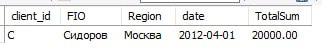

<a id='task_12_solution'></a>
### SQL2
Таблица #oper хранит информацию о количестве произведенных операций на каждую календарную дату.  
Вывести на каждую дату количества операций, совершенное с начала месяца по указанную дату включительно накопительным итогом. 
  
create table #oper (date date, cnt int) 
insert into #oper values  
('2019-06-02',     1985),  
('2019-06-03',     1577),  
('2019-06-04',     1597),  
('2019-06-05',     1468),  
('2019-07-06',     82),  
('2019-07-08',     1689),   
('2019-07-09',     1556),  
('2019-07-10',     1480),  
('2019-07-11',     1405),  
('2019-07-12',     1502)  


### Создаю и наполняю таблицы данными

```
create table oper (date DATE, cnt int); 

insert into oper values 
('2019-06-02', 1985), 
('2019-06-03', 1577), 
('2019-06-04', 1597), 
('2019-06-05', 1468), 
('2019-07-06', 82), 
('2019-07-08', 1689), 
('2019-07-09', 1556), 
('2019-07-10', 1480), 
('2019-07-11', 1405), 
('2019-07-12', 1502);
```
Здесь, на мой взгляд, уместнее и проще всего использовать оконную функцию.  
Будем считать сумму по атрибуту cnt, партиции это месяц month(date), порядок суммирования - по дате (по возрастанию), границы - от начала партиции до текущей строки

```
SELECT
  date,
  cnt,
  SUM(cnt) OVER (PARTITION BY month(date) ORDER BY date ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS oper_count
FROM oper
ORDER BY date ASC;
```
### Результат
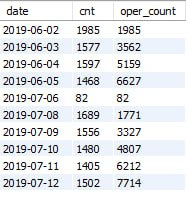

<a id='task_13_solution'></a>
### SQL3
Даны месячные срезы сегментов клиентов, нужно получить по каждому клиенту периоды действия каждого сегмента. 
  
create table #segment ([date] date, ClientID varchar(6),SegmentID int)  
insert into #segment values   
('2018-01-31' ,'A11111', 2),  
('2018-02-28' ,'A11111', 2),  
('2018-03-31' ,'A11111', 1),  
('2018-04-30' ,'A11111', 1),  
('2017-11-30' ,'B22222', 1),  
('2017-10-31' ,'B22222', 1),  
('2017-09-30' ,'B22222', 3),  
('2017-09-30' ,'C33333', 1),  
('2017-10-31' ,'C33333', 1)  


### Создаю и наполняю таблицы данными

```
create table segment (date DATE, ClientID varchar(6), SegmentID int);
 
insert into segment values  
('2018-01-31' ,'A11111', 2), 
('2018-02-28' ,'A11111', 2), 
('2018-03-31' ,'A11111', 1), 
('2018-04-30' ,'A11111', 1), 
('2017-11-30' ,'B22222', 1), 
('2017-10-31' ,'B22222', 1), 
('2017-09-30' ,'B22222', 3), 
('2017-09-30' ,'C33333', 1), 
('2017-10-31' ,'C33333', 1);
```
Группирую по клиенту и сегменту. Для каждой строки высчитываю месяц начала и окончания их действия.  
Использовал форматирование даты (оставил только месяц), посколку даны месячные срезы по сути.

```
SELECT 
  ClientID,
  SegmentID,
  DATE_FORMAT(MIN(DATE), '%Y.%m') AS StartDate,
  DATE_FORMAT(MAX(DATE), '%Y.%m') AS EndDate
FROM segment
GROUP BY ClientID, SegmentID
ORDER BY ClientID ASC, SegmentID ASC, StartDate DESC;
```
### Результат
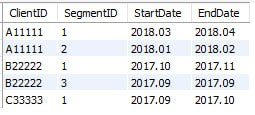

<a id='task_2'></a>

## Задание 2 (разметка и метрики)
Партнерская витрина - это набор предложений партнеров банка, которые предоставляют различного рода скидки нашим клиентам.

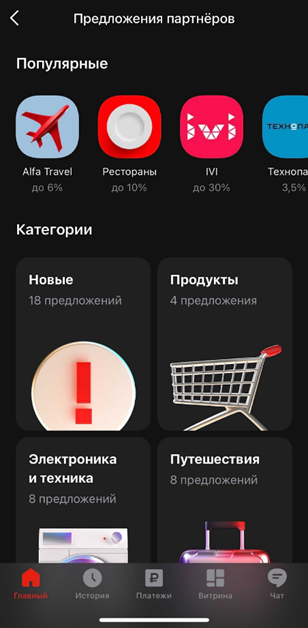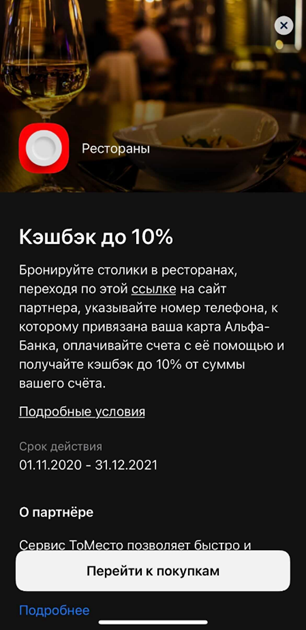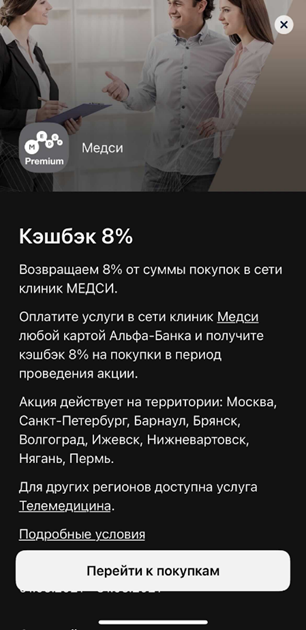  

На витрину можно перейти разными способами: через внешние и внутренние коммуникации (SMS, email, push, баннеры/уведомления внутри приложения).
Партнеры могут предоставлять данные о совершенных нашими клиентами конверсиях (транзакциях).


<a id='task_2_solution'></a>

### Какие наборы метрик для оценки эффективности партнерской витрины вы можете предложить?  
- Стоимость привлечения одного пользователя на витрину (CAC) и на сервисы партнеров;  
- CR (conversion rate) на сервисы партнеров;  
- CAR (shopping cart abandonment rate) — показатель брошенных корзин;
- ARPPU - средний чек среди пользователей, совершивших конверсии на сервисы партнеров;
- % дохода в среднем чеке от конверсий на сервисы партнеров, которую получает банк от партнеров;
- retention rate - среднее время удержания пользователя (неделя, месяц, год);
- LTV (customer lifetime value) — сколько мы в среднем зарабатываем на клиенте за период взаимодействия. 

### Опишите возможный набор систем и способы их интеграции, которые позволят осуществлять трекинг полного пути пользователя и его конверсионных действий.
#### Возможные системы:
- Google Analytics, Yandex Metrica: можно настроить отслеживание событий на страницах партнерской витрины и на страницах партнеров, чтобы отслеживать конверсии, клики, переходы по страницам и т.д.;  
- Adjust: позволяет отслеживать пользовательские события в мобильном приложении, включая переходы на витрину и конверсии, а также интегрироваться с различными сервисами партнеров;   

#### Способы интеграции:
- JavaScript код - прописывается в html коде страницы, и собирает данные о поведении пользователя;  
- Передача данных из приложений в аналитические системы используя API (Application Programming Interface);
- SDK (Software Development Kit) - готовый набор инструментов, позволяющий проводить пользовательскую аналитику в мобильных приложениях.

### Какие сырые данные нужны и в каком виде для полноты картины?
#### Необходимые типы данных:
- Затраты на рекламу и привлечение клиентов;
- Период проведения маркетинговых компаний;
- Идентификатор клиента;
- Количество входов в мобильное приложение, личный кабинет в web приложении (SMS, email, push, баннеры/уведомления внутри приложения);
- Количество просмотров партнерской витрины;
- Количество кликов на партнерскую витрину;
- Количество покупок в партнерских приложениях;
- Выручка от покупок в партнерских приложениях;
- Размер дохода от партнерской витрины.  

#### В каком виде нужны данные:
Для сбора данных о партнерской витрине в мобильном приложении необходимо собирать информацию в структурированном виде, который может быть сохранен в базе данных аналитической системы, хранилищях банка и партнеров

### Какая разметка коммуникаций и действий пользователя вам понадобится для отслеживания всего пути клиента?  
- События - любые действия пользователя, которые имеют значение для бизнеса, например, клики на кнопки, отправка форм, просмотр страниц, добавление товаров в корзину, завершение покупки и т.д.;  
- Транзакции - это действия, связанные с финансовыми операциями, такими как покупка товаров или услуг, подписка на сервисы и т.д.;    
- Сессии - временные интервалы, в течение которых пользователь находится на сайте или в приложении. Для каждой сессии нужно определить ее длительность, идентификатор, путь и другие параметры, чтобы можно было анализировать поведение пользователей;  
- Атрибуты - это дополнительные данные о клиенте, такие как возраст, пол, местоположение, язык и другие параметры, которые могут быть использованы для персонализации контента и улучшения опыта пользователя.

<a id='task_3'></a>
## Задание 3 (когортный анализ)

Приведите в качестве решения скриншот с результатом, а также свои комментарии относительно предложенного решения (с указанием среды, в которой решали задания).  

В приложенном файле хранятся данные об активности клиентов с сентября 2021 года по февраль 2022  
Необходимо на основе этих данных провести когортный анализ  

Данные: https://raw.githubusercontent.com/Propsih/test/main/data_test.csv  

Описание полей: 
* CLIENT_ID - идентификатор клиента; 
* VALUE_DAY - отчетная дата; 
* DIGITAL_30_CNT - кол-во входов в мобильное приложение за последние 30 дней на отчетную дату; 
* TRAN_ACTIVE_30_CNT - кол-во транзакций в мобильном приложение за последние 30 дней на отчетную дату; 
* OPER_ACTIVE_30_CNT - кол-во операций (транзакции+нефинансовые операции) в мобильном приложение за последние 30 дней на отчетную дату

Задачи:

*	постройте визуальное представление удержания клиентов в статусе:  
    +	активных клиентов банка (наличие строки для клиента на отчетную дату);  
    +	диджитал активных (активных в мобильном приложении: наличие хотя бы одного входа);  
    +	операционно активных;  
    +	транзакционно активных;  
*	какие выводы можно сделать на основе этих данных?;  
*	если построить проникновение транзакционно активных клиентов в когорты диджитал активных клиентов, то мы увидим, что существенная часть клиентов  использует мобильное приложение, но не совершает транзакции (платежи и переводы) в нем. Какие гипотезы такого поведения можно предположить? Как их можно  проверить ?;  
*	как можно исправить эту ситуацию и увеличить проникновение транзакционно активных клиентов в диджитал активных?

<a id='task_3_EDA'></a>

## Данное задание буду решать при помощи языка программирования python3  
используемые библиотеки:  
- pandas - анализ данных и вычисления;  
- matplotlib и seaborn для визуализации.

весь код будет скрыт, с полной версией можно ознакомиться по ссылке: https://github.com/ArTimur/test_task/blob/main/alfa_test_task3.ipynb

## Приступим, загрузим и изучим данные:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y")
df = pd.read_csv('https://raw.githubusercontent.com/Propsih/test/main/data_test.csv',
                  sep=";", parse_dates=['VALUE_DAY'], date_parser=custom_date_parser)

### посмотрим на несколько первых строк данных:

In [4]:
df.head(5)

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT
0,3596869440,2021-09-30,18.0,8.0,9.0
1,181778433,2021-09-30,7.0,3.0,3.0
2,4271531990,2021-09-30,2.0,0.0,0.0
3,3949165697,2021-09-30,15.0,4.0,5.0
4,1926920317,2021-09-30,3.0,0.0,0.0


### что из себя представляет набор (кол-во и тип данных):

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805821 entries, 0 to 805820
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CLIENT_ID           805821 non-null  int64         
 1   VALUE_DAY           805821 non-null  datetime64[ns]
 2   DIGITAL_30_CNT      711169 non-null  float64       
 3   TRAN_ACTIVE_30_CNT  711169 non-null  float64       
 4   OPER_ACTIVE_30_CNT  711169 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 30.7 MB


### количество уникальных клиентов:

In [6]:
print(df.CLIENT_ID.nunique(), "клиента")

169092 клиента


### считаем пропущенные данные:

In [7]:
df.isna().sum()

CLIENT_ID                 0
VALUE_DAY                 0
DIGITAL_30_CNT        94652
TRAN_ACTIVE_30_CNT    94652
OPER_ACTIVE_30_CNT    94652
dtype: int64

### 94652 значения отсутствует. Похоже на то, что если данные отсутствуют по одному показателю, то их нет и по остальным. Но необходимо это проверить:  
### отфильтрую все пустые значения по столбцу "DIGITAL_30_CNT" (например)  и просуммирую все три показателя. 

In [8]:
df.query("DIGITAL_30_CNT.isna()")[['DIGITAL_30_CNT', 'TRAN_ACTIVE_30_CNT', 'OPER_ACTIVE_30_CNT']].sum()

DIGITAL_30_CNT        0.0
TRAN_ACTIVE_30_CNT    0.0
OPER_ACTIVE_30_CNT    0.0
dtype: float64

### Так как все данные показетелей равны нулю, то утверждаемся в мысли, что в датасете представленны:  
1) все клиенты банка, которые проявляют активность как оф, так и онлайн - все уникальные клиенты в датасете;  
2) клиенты, по которым есть показатели, - имеют установленное мобильное приложение.  
- могут в него заходить (DIGITAL_30_CNT);
- совершать транзакции (TRAN_ACTIVE_30_CNT);
- проводить нефинансовые операции (OPER_ACTIVE_30_CNT).
    


>У меня были сложности с интерпретацией задачи, т.к. я обнаружил, что есть клиенты, которые не заходили в мобильный банк в течении отчетного месяца, но при этом совершали транзакции/операции.  
Не могу понять как это возможно. Предположил, что транзакции и операции могли быть сделаны офлайн, но в описании полей указано - мобильное приложение.    

>После длительных рассуждений сделал допущения: либо я знаю не все (например, операцией может быть получение документа, заказанного ранее), либо есть ошибка в данных. С этим обязательно надо разбираться отдельно, тк от этого зависит корретность дальнейшего отчета и выводы.
Пример нестыковок:

In [9]:
df.groupby(['CLIENT_ID', 'VALUE_DAY']).sum().query("DIGITAL_30_CNT == 0 and (TRAN_ACTIVE_30_CNT > 0 or OPER_ACTIVE_30_CNT > 0)").head()

DIGITAL_30_CNT  TRAN_ACTIVE_30_CNT  OPER_ACTIVE_30_CNT
CLIENT_ID VALUE_DAY                                                         
17866400  2021-12-31             0.0                 1.0                 1.0
19677355  2022-01-31             0.0                 2.0                 2.0
20338831  2021-10-31             0.0                 1.0                 1.0
          2021-11-30             0.0                 1.0                 1.0
22256088  2021-09-30             0.0                 1.0                 1.0

In [10]:
print("всего таких записей", df.groupby(['CLIENT_ID', 'VALUE_DAY']).sum().query("DIGITAL_30_CNT == 0 and (TRAN_ACTIVE_30_CNT > 0 or OPER_ACTIVE_30_CNT > 0)").shape[0], "шт")
print("по уникальным клиентам в кол-ве", df.groupby(['CLIENT_ID', 'VALUE_DAY']).sum().query("DIGITAL_30_CNT == 0 and (TRAN_ACTIVE_30_CNT > 0 or OPER_ACTIVE_30_CNT > 0)").index.get_level_values(0).nunique(), "шт")

всего таких записей 2490 шт
по уникальным клиентам в кол-ве 1433 шт


In [11]:
# df2 = df.copy()

In [12]:
# df2['DIGITAL_30_True'] = np.where(df.DIGITAL_30_CNT > 0, True, False)
# df2['TRAN_ACTIVE_30_True'] = np.where(df.TRAN_ACTIVE_30_CNT > 0, True, False)
# df2['OPER_ACTIVE_30_True'] = np.where(df.OPER_ACTIVE_30_CNT > 0, True, False)
# df2

In [13]:
# df2.groupby(['VALUE_DAY'])[['DIGITAL_30_True', 'TRAN_ACTIVE_30_True', 'OPER_ACTIVE_30_True']].sum()

<a id='task_3_solution_v'></a>

## Построим визуальное представление удержания клиентов в статусе:  
- активных клиентов банка (наличие строки для клиента на отчетную дату);  
- диджитал активных (активных в мобильном приложении: наличие хотя бы одного входа);  
- операционно активных;  
- транзакционно активных; 

## Для этого выполним ряд расчетов:

1) Найдем дату первого взаимодействия каждого пользователя с системой (определим его когорту)  
2) Вычислим жизненный цикл когорты в месяцах для каждого пользователя (VALUE_DAY минус дата первого взаимодействия)  
3) Посчитаем кол-во пользователей на каждом жизненном цикле каждой когорты  
4) Определим первоначальный состав когорт  
5) Посчитаем retention по формуле: кол-во пользователей на определенном жизненном цикле когорты / кол-во пользователей в первоначальном составе когорты  

## Построим одну визуализацию для всех статусов, это облегчит восприятие и последующий анализ.
По оси X - retention по мес: 1 (окт 21) по 5 (февраль 22) (0 месяц пропущу, чтобы не нагружать график лишней информацией). Также отражу первоначальный размер когорты (coh size)  

По оси Y - когорты


In [14]:
def cohort_analysis(df: pd.DataFrame, title: str):
  # находим дату первого взаимодействия каждого пользователя с системой (определяем его когорту) и добавляем соотвествующий столбец
  df_reg = df.groupby("CLIENT_ID", as_index=False).agg({'VALUE_DAY' : 'min'})
  df_reg.columns = ['CLIENT_ID', 'registration_date']
  df_merged = df.merge(df_reg, how='left', on='CLIENT_ID')
  
  # вычисляем жизненный цикл когорты
  df_merged['cohort_lifetime'] = round((df_merged.VALUE_DAY - df_merged.registration_date)/np.timedelta64(1, 'M'), 0) \
    .astype(int)
  
  # считаем кол-во пользователей на каждом жизненном цикле каждой когорты
  cohorts = df_merged.pivot_table(index = ['registration_date','cohort_lifetime'], 
                                  aggfunc = {'CLIENT_ID':'nunique'}).reset_index()
  
  # определяем первоначальный состав когорты (кол-во клиентов)
  initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
  initial_users_count = initial_users_count[['registration_date','CLIENT_ID']]
  initial_users_count = initial_users_count.rename(columns={'CLIENT_ID':'cohort_users'})

  # считаем retention
  cohorts = cohorts.merge(initial_users_count,on='registration_date')
  cohorts['retention'] = cohorts['CLIENT_ID']/cohorts['cohort_users'] 
  retention_pivot = cohorts.pivot_table(index='registration_date',
                                        columns='cohort_lifetime',
                                        values='retention',
                                        aggfunc='sum') 
  
  return retention_pivot, initial_users_count

In [15]:
# считаем retention для 
cohort_active = cohort_analysis(df, 'active')[0]
cohort_digital_active = cohort_analysis(df.query('DIGITAL_30_CNT > 0'), 'digital active')[0]
cohort_oper_active = cohort_analysis(df.query('OPER_ACTIVE_30_CNT > 0'), 'oper active')[0]
cohort_trans_active = cohort_analysis(df.query('TRAN_ACTIVE_30_CNT > 0'), 'trans active')[0]

In [16]:
# размер каждой когорты в разрезах типа клиентов
cohort_active_size = cohort_analysis(df, 'active')[1].cohort_users[:-1]
cohort_digital_active_size = cohort_analysis(df.query('DIGITAL_30_CNT > 0'), 'digital active')[1].cohort_users[:-1]
cohort_oper_active_size = cohort_analysis(df.query('OPER_ACTIVE_30_CNT > 0'), 'oper active')[1].cohort_users[:-1]
cohort_trans_active_size = cohort_analysis(df.query('TRAN_ACTIVE_30_CNT > 0'), 'trans active')[1].cohort_users[:-1]

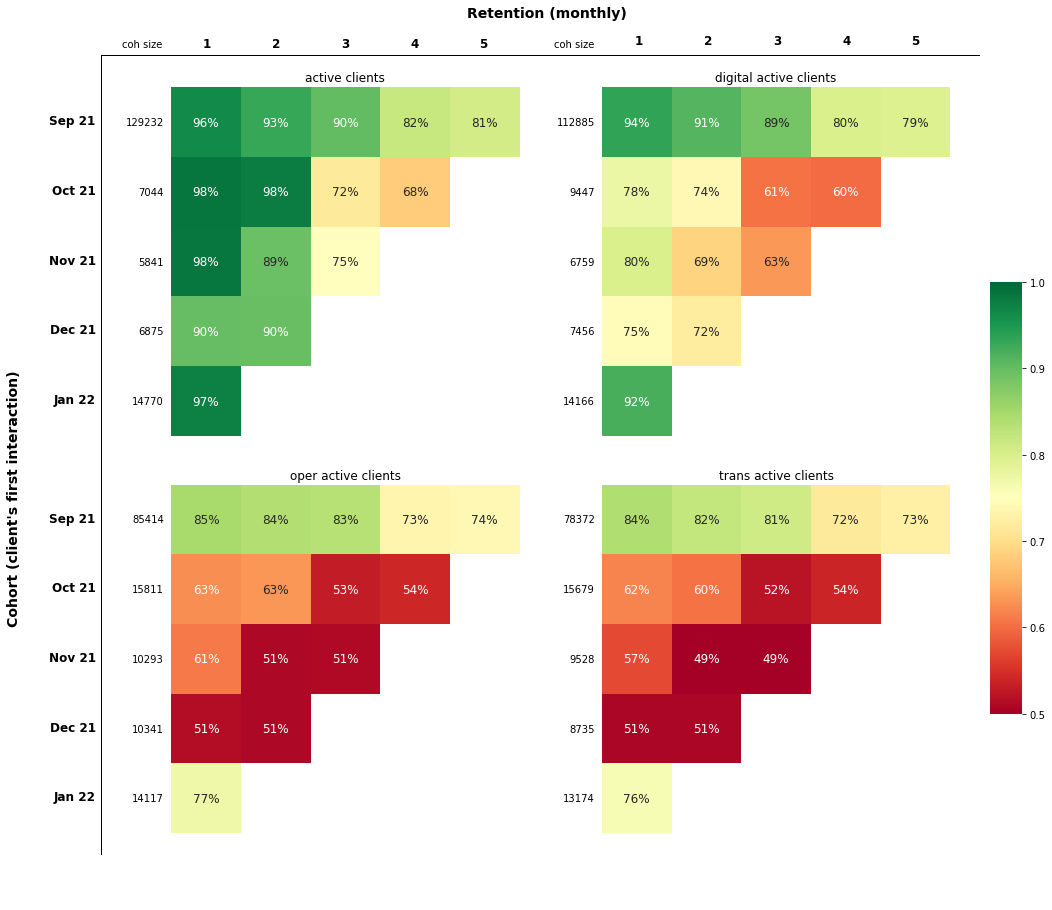

In [17]:
f, axs = plt.subplots(2, 2, sharex=True, figsize=(15, 15))
# plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
f.text(0.5, .945, 'Retention (monthly)', ha='center', fontsize=14, fontweight='bold')
f.text(.0, .5, 'Cohort (client\'s first interaction)', va='center', fontsize=14, rotation='vertical', fontweight='bold')
f.add_artist(plt.Line2D([0.087, .90], [0.91, 0.91], color='black', lw=1))
f.add_artist(plt.Line2D([0.087, 0.087], [0.17, .91], color='black', lw=1))

for i in range(2):
  f.text(i * .4 + .125, .917, 'coh size', ha='center', fontsize=10)

month = [1, 2, 3, 4, 5]
for i in range(len(month)):
  f.text(i * .064 + .185, .917, month[i], ha='center', fontsize=12, fontweight='bold')

for i in range(len(month)):
  f.text(i * .064 + .585, .92, month[i], ha='center', fontsize=12, fontweight='bold')  

month_coh = ['Sep 21', 'Oct 21', 'Nov 21', 'Dec 21', 'Jan 22'][::-1]
for i in range(5):
  f.text(.082, i * .0645 + .223,  month_coh[i], ha='right', va='center', fontsize=12, fontweight='bold')

for i in range(5):
  f.text(.082, i * .0645 + .591, month_coh[i], ha='right', va='center', fontsize=12, fontweight='bold')  


plt.yticks(rotation=0) 
yticks = cohort_active.index[:-1].strftime('%Y-%m-%d')
g1 = sns.heatmap(cohort_active.iloc[:, 1:], cmap='RdYlGn', cbar=True, cbar_ax=f.add_axes([.91, .3, .03, .4]), ax=axs[0, 0], yticklabels=cohort_active_size, annot=True, square=True, vmin=0.5, vmax=1, fmt='.0%', annot_kws={"fontsize":12})
g1.set_title('active clients')
g1.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)

g2 = sns.heatmap(cohort_digital_active.iloc[:, 1:], cmap='RdYlGn', cbar=False, ax=axs[0, 1], yticklabels=cohort_digital_active_size, annot=True, square=True, vmin=0.5, vmax=1, fmt='.0%', annot_kws={"fontsize":12})
g2.set_title('digital active clients')
g2.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=False)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticklabels(g2.get_yticklabels(), rotation=0)

g3 = sns.heatmap(cohort_oper_active.iloc[:, 1:],  cmap='RdYlGn', cbar=False, ax=axs[1, 0], yticklabels=cohort_oper_active_size, annot=True, square=True, vmin=0.5, vmax=1, fmt='.0%', annot_kws={"fontsize":12})
g3.set_title('oper active clients')
g3.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=False)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticklabels(g3.get_yticklabels(), rotation=0)

g4 = sns.heatmap(cohort_trans_active.iloc[:, 1:],  cmap='RdYlGn', cbar=False, ax=axs[1, 1], yticklabels=cohort_trans_active_size, annot=True, square=True, vmin=0.5, vmax=1, fmt='.0%', annot_kws={"fontsize":12})
g4.set_title('trans active clients')
g4.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=False)
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_yticklabels(g4.get_yticklabels(), rotation=0)

plt.subplots_adjust(hspace=-0.05, wspace=0.06)
plt.show()

<a id='task_3_solution_output'></a>

## Выводы на основе визуализации данных:

В сентябре пришло самое большое кол-во пользователей, это прослеживается по всем типам активности. По сравнению с остальными периодами отличие в среднем грубо x7 - x15.  
Также retention по сентябрьской когорте самый высокий.  

Такие явные отклонения могут свидетельствовать о крупной маркетинговой компании в сентябре 21г по привлечению клиентов совместно с партнерами банка. В программе, вероятно, пользователям предоставлялись материальные поощрения при использовании моб. приложения (скидки/пониженные тарифы/повышенный кешбек/переводы без комиссии/беспроцентные рассрочки/скидки у партнеров и пр.) c длительным периодом действия - судя по retention от 5 месяцев и далее.  
Это косвенно подтверждается операционной и транзакционной активностью пользователей сентябрьской когорты в последующие месяцы.

Судя по тому, что у когорт, начиная с октября, резко снижается удержание в мобильном приложении, можно предположить, что кампания закончилась и клиенты, пришедшие в эти периоды, не мотивированы на его использование для совершения каких-либо операций. В лучшем случае клиенты просто проверяют баланс - это можно предположить исходя из того, что диджитал активность заметно выше, чем транзакционная и оперативная.

В дополнение к этому можно предположить, что у приложения есть проблемы с UX/UI дизайном, или есть зависания, ошибки. Клиенты готовы с этим мириться только с учетом материальной выгоды, в противном случае они довольствуются офлайн услугами - ретеншн активных пользователей не так драматично изменяется.  
В январьской когорте заметно улучшение показателя по всем статусам клиентов + рост самой кагорты - возможно, были внесены исправления в работу приложения, но данные за один месяц не позволяют делать такие выводы.

Для подтверждения, опровержения и выработки новых гипотез необходима доп. информация от подразделений банка, отвечающих за маркетинговые компании, поддержку клиентов, и развитие мобильного приложения. Стоит выяснить портрет пользователя: возраст, пол, и прочие.

<a id='task_3_solution_output2'></a>
## Существенная часть клиентов  использует мобильное приложение, но не совершает транзакции (платежи и переводы) в нем.  
<a id='task_3_solution_output21'></a>
### Какие гипотезы такого поведения можно предположить?  
- Клиенты используют приложение только для просмотра информации о своем балансе или услугах банка, но для совершения транзакций предпочитают другие каналы;  
- Высокие комиссии за транзакции/операции;  
- Некоторые клиенты не имеют необходимых на данный момент финансовых операций, но сохраняют приложение для будущих транзакций;  
- Проблемы UX/UI (неудобный, непонятный интерфейс), технические проблемы (баги, зависания, медленное выполнение операций и прочее), высокие требования к скорости интернета;  
- Клиенты не доверяют безопасности приложения.  

<a id='task_3_solution_output22'></a>
### Как их можно проверить?  
- Исследовать поведение клиентов внутри приложения (Amplitude, Google Analytics, Y Metrica и прочие), чтобы выяснить, на каких этапах они отказываются от совершения транзакций;  
- Анализировать данные о проблемах, связанных с использованием приложения, о которых пользователи сообщают в службу поддержки;  
- Исследовать рынок и провести анализ конкурентов, чтобы выяснить, какие функции, услуги предоставляют другие приложения банков, которые клиенты могут использовать как альтернативу, сравнить тарифную политику;  
- Провести тестирование пользовательского интерфейса (AB тесты): может помочь понять, как пользователи взаимодействуют с приложением и насколько легко им пользоваться.
- Провести опрос среди клиентов, чтобы выяснить, почему они используют приложение, но не совершают в нем транзакции.  

<a id='task_3_solution_output23'></a>
### Как можно исправить эту ситуацию и увеличить проникновение транзакционно активных клиентов в диджитал активных?  
- Улучшить пользовательский интерфейс (UX/UI), наладить процесс оптимизации интерфейса и предоставить более полезные функции;  
- Предоставить бонусы, скидки и боле востребованные партнерские программы по сравнению с конкурентами;
- Реклама и маркетинг: Чтобы привлечь больше клиентов, необходимо проводить рекламные и маркетинговые кампании. Можно использовать различные каналы, такие как социальные сети и поисковые системы, чтобы привлечь новых клиентов и повысить осведомленность о диджитал активах.


<a id='task_4'></a>

## Задание 4 Сделайте мини-портфолио по 2-3 сделанным вами ранее отчетам/исследованиям (чувствительную информацию можете упустить, если прикладываете скрины отчетов - “заблюрить” значения):
-	какая цель и задачи стояли, какие пользователи результата;  
-	для исследований - какие методы и инструменты были выбраны;  
-	опишите источники данных, требовались ли доработки в источниках для обеспечения полноты данных и для матчинга;  
-	какие инструменты использовались для выгрузки данных из источников и для их объединения, для автоматизации;  
-	каким образом производился матчинг данных разных систем-источников;  
-	какие средства визуализации использовались и каким образом выглядел конечный результат.


<a id='weekly_report'></a>
### 1 Еженедельный сводный отчет по прогнозу продаж (weekly report).

Отражает фактическую динамику объемных показателей за пройденный период + прогноз предстоящих периодов, в разрезе baseline и promo продаж.

#### Пользователи:
* Sales - контролирует выполнение целевых показателей;  
* Маркетинг - проверяет насыщенность promo;  
* Производственные площадки - определяют уровень загрузки мощности;  
* Закупки - проверяют потенциал образования дефицита сырья и материалов;
* Складская логистика - сверяет уровень запаса готовой продукции на складах и потенциал ее срабатывания;
* Финансовая служба - расчитывает финансовые показатели на основе объема

Sales и маркетинг ориентируются по отчету, для остальных подразделений предоставлена возможность выгрузить данные для более детальной и глубокой аналитики 

#### Для составления используется:  
* План и бюджет (csv) выкладывается на сервер, откуда он подгружется в QlikView;
* Факт продаж. Подгружается из CRM системы MS Axapta напрямую в QlikView; 
* Прогноз продаж. Состоит из нескольких частей:  
    + baseline - рассчитывается на основании сезонных коэф-ов (ведется справочник, периодически пересчитывается), статистики средних продаж (SQL запрос к MS SQL server), очищенных от промо, за последние несколько недель (от 4 до 8, в зависимости от специфики продукта и канала продаж);
    + promo ближайший горизонт (1-2 месяца, в зависимости от товарной категории) - используются расчетные данные аналитиков по прогнозированию (excel, ранее SAP APO);
    + promo дальний горизонт - данные трейд маркетинга по планируемым promo (SQL запрос к MS SQL server). Плюс данные от Дистрибьюторов (excel)

#### Прогнозная часть полностью собирается через python3:  
- На входе: справочники (сезонность, номенклатура, наименование клиентов, график выборки продукции клиентами), статистика продаж, данные по промо от аналитиков и продаж;  
- Внутри: при помощи встроенного функционала языка и аналитических библиотек данные парсятся (объемы раскладываются по необходимым периодам, формируются недостающие столбцы атрибутов), номенклатура и клиенты матчатся через справочники;
- На выходе: датасет (csv) - выкладывается на сервер, откуда он подгружется в QlikView

#### Алгоритм и логику построения отчета в QlikView согласовал с внутренними заказчиками и сформировал ТЗ в it отдел компании.

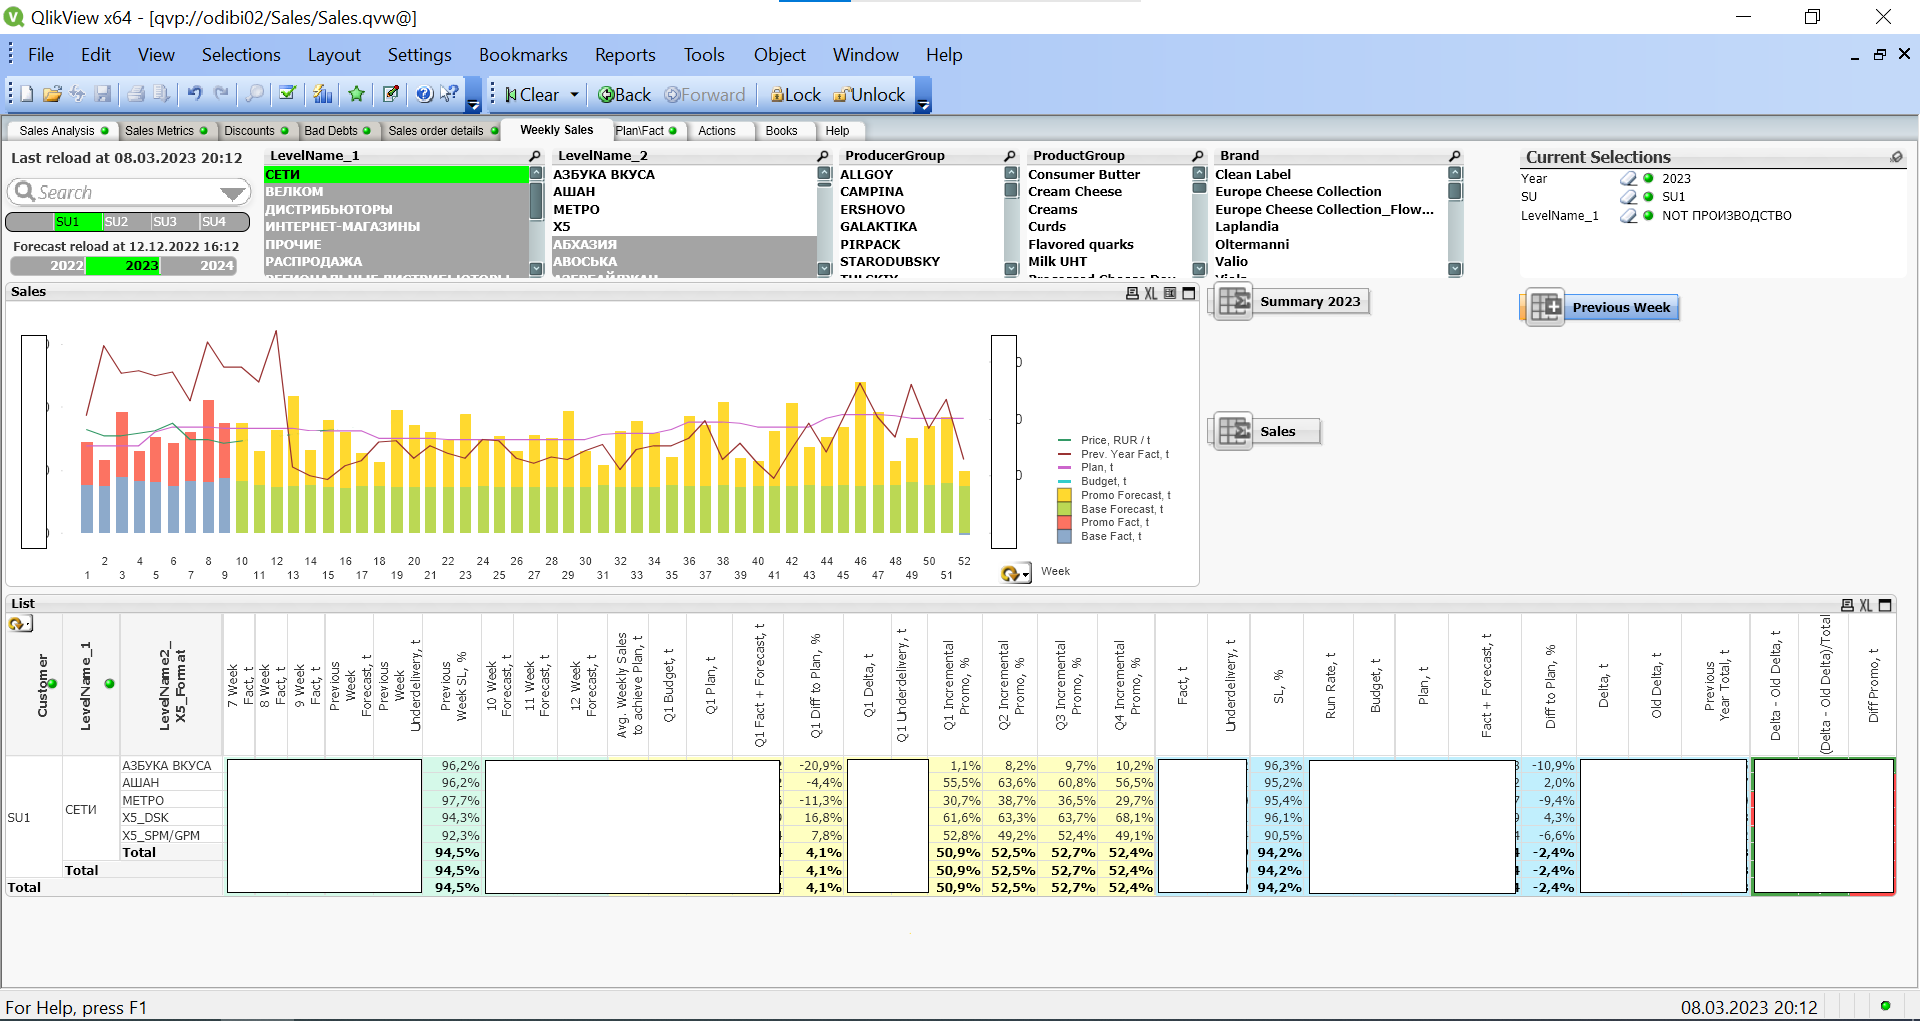

<a id='calc'></a>
### 2 Автоматический расчет promo объемов.
Позволяет аналитикам оперативно производить расчеты маркетинговых компаний на основании статистики прошлых периодов

### Задача - сократить время на расчеты и увеличить точность прогноза

### Алгоритм в общих чертах:  
1 Расчет статистики
- вычисляется baseline, путем очистки данных от влияния скидок в прошлом;
- вычисляется объем incremental по каждой компании в разрезе: клиент, номенклатура, склад, тип акции, %скидки;
- рассчитывается коэф incremental.  

2 Расчет прогноза
- Фильтруется статистика в соответствии с параметрами промо: тип акции, номенклатура, скидка, клиент;
- Вычисляется средний коэф incremental по стат данным;
- Средние продажи умножаются на коэф incremental;  
>Если данных недостаточно, то система прелагает подобрать параметры в ручную: выбрать похожие продукты, посчитать по продуктовым группам, сделать расчет прироста на основании данных продаж другого клиента. Также перед расчетом можно настроить параметры: за какой период смотреть статистику промо и средних продаж.

### Инструментарий:
Все расчеты и алгоритм "зашит" в MS Axapta. Мной разработан алгоритм, совмество c it отделом компании составлено ТЗ. Реализовано аутсорс компанией Корус Консалтинг






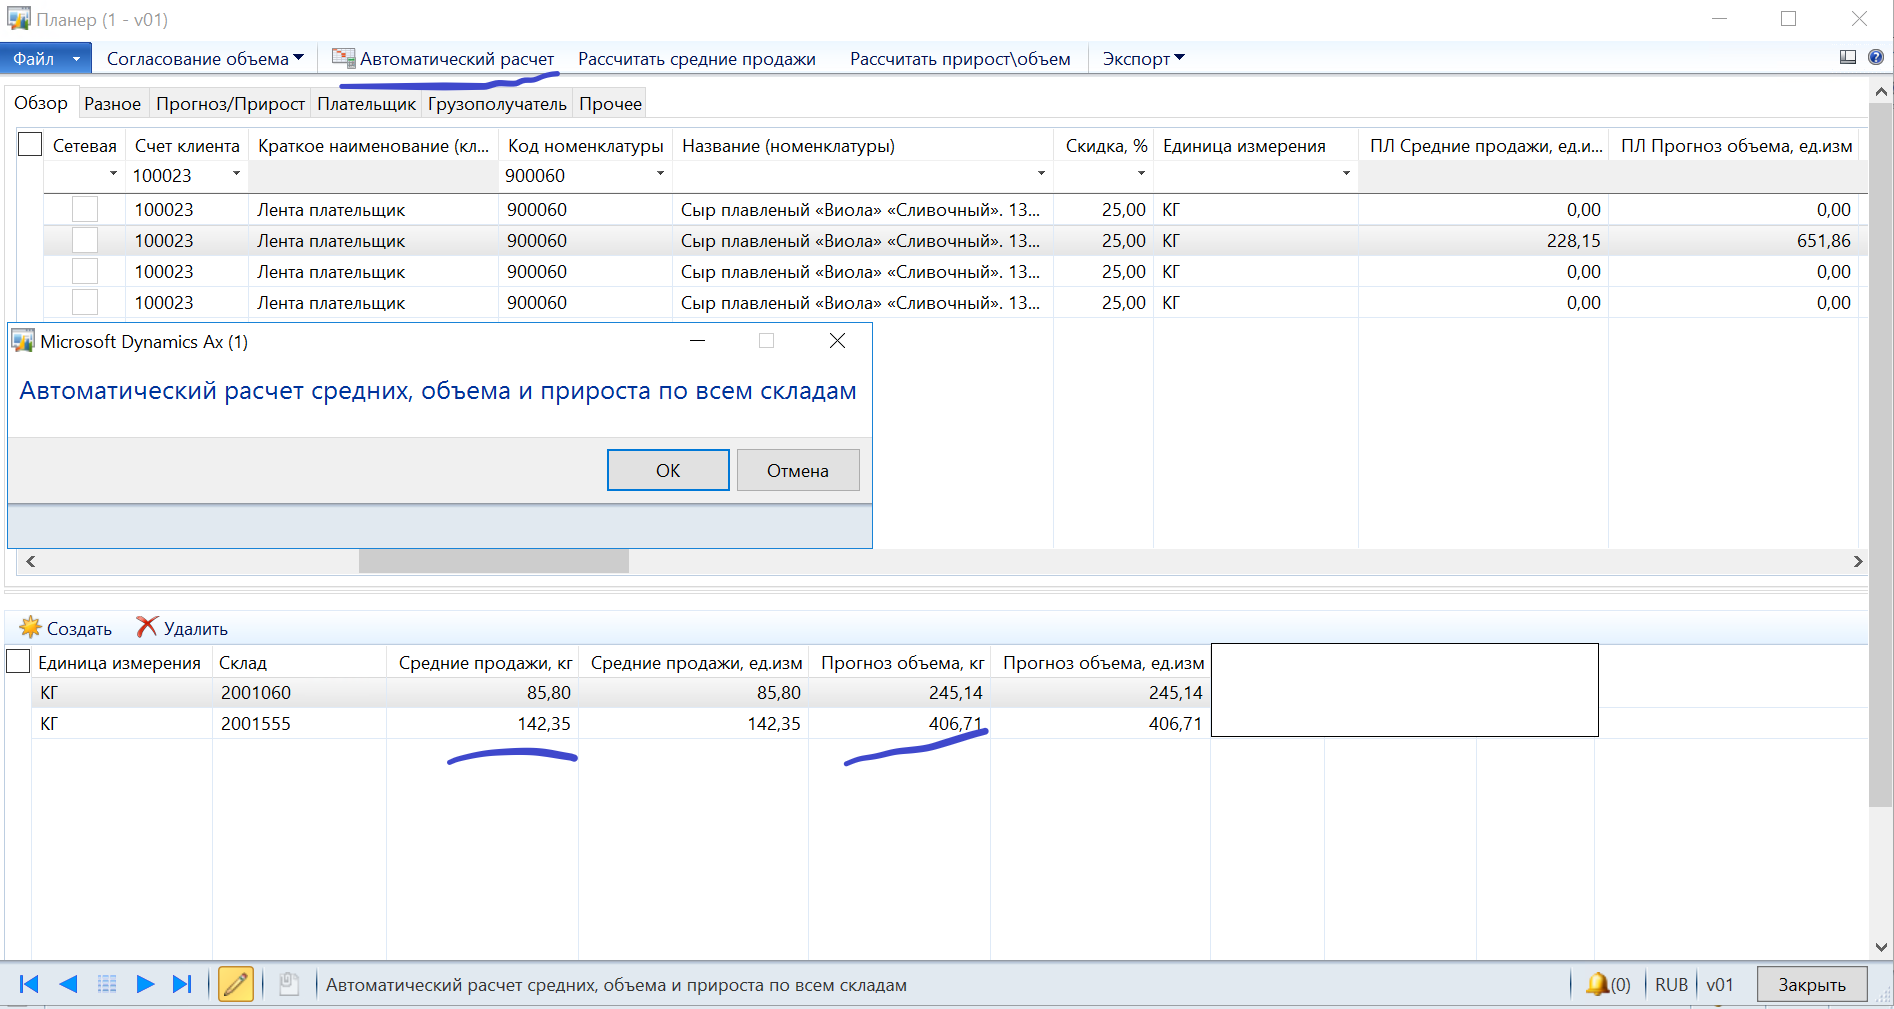

<a id='stud'></a>
### 3 Ссылка на мой учебный проект в рамках Karpov.Courses
- https://github.com/ArTimur/DA_projects/blob/master/projects/final_project.ipynb

#### Контакты
<a href="mailto: mrtimmag@gmail.com"><img src="https://img.shields.io/badge/Gmail-D14836?style=for-the-badge&logo=gmail&logoColor=white"></a>
<a href="https://t.me/T_i_m_T_i_m"><img src="https://img.shields.io/badge/-Telegram-27A7E7?style=for-the-badge&logo=telegram"></a>

[Вернуться в начало](#start)